In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm

# 2. Calculate the lower-resolution array by averaging 10x10 blocks
def block_mean(array, block_size):
    shape = (array.shape[0] // block_size, array.shape[1] // block_size, block_size, block_size)
    return array.reshape(shape).mean(axis=(2, 3))

In [2]:
# Parameters
high_res_shape = (100, 100)  # Shape of the high-resolution array
block_size = 5  # Block size for averaging

# 1. Create a synthetic higher-resolution array with a gradient of zero inflation
np.random.seed(42)  # For reproducibility
A = 4 * np.random.rand(100, 100) - 2

# Introduce zeros at the "top" (surface) of the array
decay_rate = 0.005
zero_inflation_factor = np.exp(-decay_rate * np.arange(high_res_shape[0])).reshape(-1, 1)
A *= zero_inflation_factor

# 2. Calculate the lower-resolution array by averaging 10x10 blocks
def block_mean(array, block_size):
    shape = (array.shape[0] // block_size, array.shape[1] // block_size, block_size, block_size)
    return array.reshape(shape).mean(axis=(2, 3))

In [ ]:
# Parameters for the array
rows, cols = 100, 100  # Dimensions of the array
x = np.linspace(0, 2 * np.pi, cols)  # X-axis for sine wave 
y = np.linspace(0, 2 * np.pi, rows)  # Y-axis represents depth
x_grid, y_grid = np.meshgrid(x, y)

# Generate a sine wave along the rows. 
sin_wave = np.sin(x_grid)  # Increased period by extending the x range

# Add random noise
noise = np.random.uniform(-0.2, 0.2, size=(rows, cols))  # Random noise
sin_with_noise = sin_wave + noise

# Introduce random zeros at the surface
zero_inflation = np.exp(-np.linspace(0, 5, rows))[:, np.newaxis]  # Exponential decay with depth
zero_mask = np.random.rand(rows, cols) < zero_inflation  # Random zeros based on depth
sin_with_zeros = np.where(zero_mask, 0, sin_with_noise)  # Apply zeros at the surface

# bad on memory but small for now. 
A = np.flip(sin_with_zeros)
B = block_mean(A, block_size)

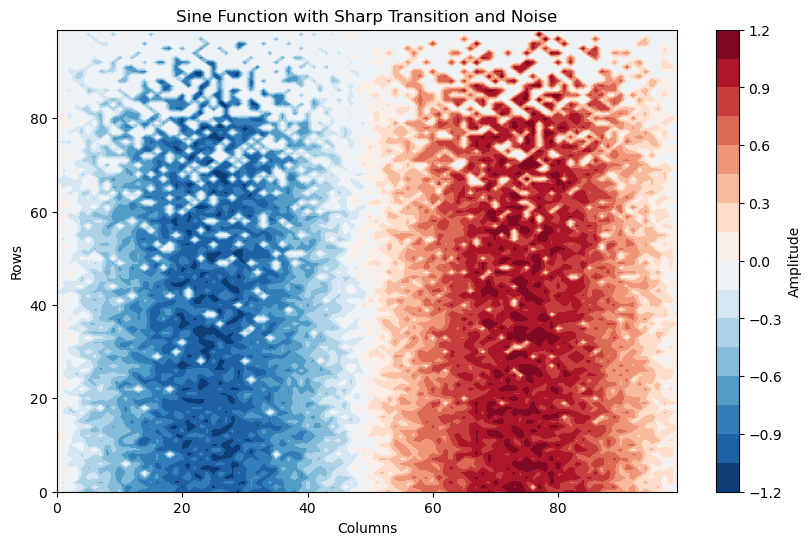

In [16]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.contourf(A, levels=20, cmap="RdBu_r")
plt.colorbar(label="Amplitude")
plt.title("Sine Function with Sharp Transition and Noise")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [8]:
from sklearn.mixture import GaussianMixture

# Flatten each block to a 1D array for fitting
block_flat = A[:block_size, :block_size].flatten()  # Example: first block

# Fit a 2-component Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(block_flat.reshape(-1, 1))

# Predict which component each value belongs to
labels = gmm.predict(block_flat.reshape(-1, 1))

# Compute the mean of the "true" component (assuming it's component 1)
true_component = 1 if gmm.means_[1] > gmm.means_[0] else 0
true_values = block_flat[labels == true_component]
true_mean = np.mean(true_values)

print("Estimated true mean for block:", true_mean)

Estimated true mean for block: 0.772676287164858


In [9]:
corrected_B = np.zeros_like(B)
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        block = A[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size].flatten()
        gmm.fit(block.reshape(-1, 1))
        true_component = 1 if gmm.means_[1] > gmm.means_[0] else 0
        true_values = block[gmm.predict(block.reshape(-1, 1)) == true_component]
        corrected_B[i, j] = np.mean(true_values) if len(true_values) > 0 else 0

print("Corrected lower-resolution array B:\n", corrected_B)

Corrected lower-resolution array B:
 [[0.77267629 0.73079252 0.69416409 0.67342393 0.69892918 0.75823694
  0.72844335 0.72082811 0.7450376  0.73875025]
 [0.7137838  0.83693816 0.72193317 0.78019611 0.79811404 0.80220928
  0.67922879 0.70179958 0.80369229 0.8265125 ]
 [0.7230769  0.71950768 0.79379538 0.72288636 0.86016918 0.7476183
  0.67830533 0.75412545 0.82801317 0.73680991]
 [0.67263957 0.83847875 0.74420867 0.78299384 0.77018444 0.72705691
  0.69874874 0.7167669  0.77317769 0.72506212]
 [0.76256178 0.75140189 0.72095265 0.67246385 0.74335821 0.77979912
  0.76681191 0.88028534 0.81270624 0.67671169]
 [0.72897925 0.75391286 0.75454221 0.77363545 0.74796554 0.70740818
  0.70782768 0.77401793 0.80211372 0.72713943]
 [0.67720151 0.71794952 0.78243114 0.79397042 0.77292154 0.75837411
  0.75990214 0.73030375 0.73356801 0.87844892]
 [0.8348368  0.59786302 0.82669027 0.7458174  0.73008213 0.69670548
  0.75917139 0.73826238 0.73032084 0.76874539]
 [0.76830031 0.7591131  0.69867678 0.7560637

In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Example higher-resolution array A (100x100)
A = np.random.rand(100, 100)  # Replace this with your actual array
A[A < 0.1] = 0  # Simulate zero inflation

# Define block size
block_size = 10

# 1. Select a representative subset of A
subset = A.flatten()[:1000]  # Example: first 1000 values (adjust based on data size)

# 2. Fit the GMM on the subset
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(subset.reshape(-1, 1))

# Identify which component corresponds to the "true" values
true_component = 1 if gmm.means_[1] > gmm.means_[0] else 0

# 3. Apply the pre-fitted GMM to predict all blocks
def block_mean(array, block_size):
    shape = (array.shape[0] // block_size, array.shape[1] // block_size, block_size, block_size)
    return array.reshape(shape).mean(axis=(2, 3))

B = block_mean(A, block_size)  # Initialize B (unadjusted means)

corrected_B = np.zeros_like(B)
for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        block = A[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size].flatten()
        # Predict the true component for the block
        predicted_labels = gmm.predict(block.reshape(-1, 1))
        true_values = block[predicted_labels == true_component]
        corrected_B[i, j] = np.mean(true_values) if len(true_values) > 0 else 0

Corrected lower-resolution array B:
 [[0.76320999 0.75893983 0.74719605 0.77473352 0.76427208 0.72986641
  0.73148243 0.74829759 0.69743277 0.79345359]
 [0.76074101 0.7287117  0.75334639 0.72258364 0.75916054 0.76302586
  0.80310579 0.77937946 0.7180685  0.77210081]
 [0.78571452 0.77650819 0.76405026 0.78301817 0.7985234  0.73666816
  0.74816623 0.78781259 0.73550616 0.74970225]
 [0.78811164 0.80556433 0.76442291 0.7625973  0.76481039 0.75640473
  0.78056484 0.75199566 0.75747971 0.75868555]
 [0.70837865 0.72725304 0.77936855 0.72720968 0.72907655 0.7200756
  0.76100038 0.77106829 0.75713876 0.75335147]
 [0.77155862 0.71913939 0.76844801 0.77330291 0.76511516 0.76033643
  0.74765175 0.77411392 0.72121024 0.75228071]
 [0.73867251 0.73987857 0.77315436 0.77745067 0.78269808 0.75651322
  0.77369255 0.72335048 0.73703421 0.74485673]
 [0.74259224 0.75070623 0.75897246 0.79639337 0.73721122 0.75553049
  0.76194385 0.77253826 0.73171466 0.73127854]
 [0.72910355 0.75619615 0.75884157 0.7561989

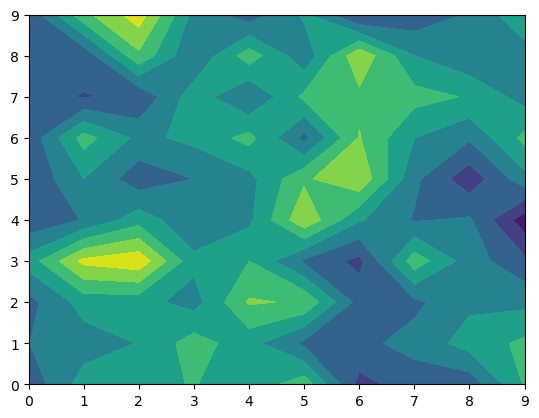

In [11]:
plt.contourf(B)